In [648]:
# package to collect reddit data
import praw
import psaw

import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None) # show all columns
import numpy as np
import os
#from tqdm import trange, tqdm, tqdm_notebook
from tqdm.notebook import tqdm_notebook # to visualize the progress of code execution
import sys # for file and directory access
import unidecode
import functools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "whitegrid")

# packages to deal with data
import sklearn as skl
from sklearn import feature_extraction, pipeline, decomposition, cluster, manifold, preprocessing
## language proceessing libs
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download("wordnet")
import spacy
from spacy.lang.en import English
spacy.prefer_gpu() #enable gpu
from word2number import w2n
import string
import re
from gensim import corpora, models, similarities, matutils
from corextopic import corextopic


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yahoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yahoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yahoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df_all = pd.read_csv("src/data/original_data/AITA_all.csv")
df_ass = pd.read_csv("src/data/original_data/AITA_ass.csv")
df_not = pd.read_csv("src/data/original_data/AITA_not.csv")

# check if df ass/not/all has deleted post if so remove
print("shape of df ass: "+str(df_ass.shape))
print("shape of df not: "+str(df_not.shape))
print("shape of df all: "+str(df_all.shape))

print("shape of df ass after removing samples of deleted post: "+str(df_ass[df_ass["selftext"] != "[deleted]"].shape))
print("shape of df not after removing samples of deleted post: "+str(df_not[df_not["selftext"] != "[deleted]"].shape))
print("shape of df all after removing samples of deleted post: "+str(df_all[df_all["selftext"] != "[deleted]"].shape))

# removing samples with no selftext (post is deleted)
df_ass = df_ass[df_ass["selftext"] != "[deleted]"]
df_not = df_not[df_not["selftext"] != "[deleted]"]
df_all = df_all[df_all["selftext"] != "[deleted]"]

df_ass.reset_index(drop = True, inplace = True)
df_not.reset_index(drop = True, inplace = True)
df_all.reset_index(drop=True, inplace = True)


# select samples from df_all that is either tagged as not a asshole or a asshole
mask = (df_all["link_flair_css_class"] == "not") | (df_all["link_flair_css_class"] == "ass")
df_all = df_all[mask]
df_all.reset_index(drop = True, inplace = True)
print("shape of df all with submissions tagged as either not a a*hole or a* hole")
print(df_all.shape)

shape of df ass: (4421, 33)
shape of df not: (10000, 33)
shape of df all: (16000, 33)
shape of df ass after removing samples of deleted post: (4043, 33)
shape of df not after removing samples of deleted post: (9409, 33)
shape of df all after removing samples of deleted post: (13758, 33)
shape of df all with submissions tagged as either not a a*hole or a* hole
(6503, 33)


In [6]:
# check if there are overlapping samples from df_all that is either in df_not or df_ass
df_meta = pd.concat([df_all, df_not, df_ass], axis = 0)
df_meta.reset_index(drop = True, inplace = True)

# number of post grouped by flairs (ass, not)
print(df_meta.drop_duplicates(ignore_index = False).groupby(["link_flair_css_class"]).count()["selftext"])

# update
df_meta.drop_duplicates(ignore_index = True, inplace = True)


# remove columns that are not needed
cols_toremove = ['created_utc', 'subreddit', 'author', 'domain', 'saved' , 'from_kind', 'gilded', 
                 'from', 'stickied','retrieved_on','thumbnail', 'subreddit_id', 'hide_score','is_self',
                 'from_id','name','author_flair_css_class', 'author_flair_text',
                 'quarantine', 'link_flair_text', 'distinguished']
df_meta.drop(columns = cols_toremove, inplace = True)
df_meta.head()

link_flair_css_class
ass    4043
not    9570
Name: selftext, dtype: int64


,url,num_comments,score,title,selftext,id,over_18,link_flair_css_class,archived,permalink
0,https://www.reddit.com/r/AmItheAsshole/comment...,33,12,AITA for my fantasy football league name?,"My team includes Ted Ginn, Julian Edelman, and...",cum4ob,False,ass,False,/r/AmItheAsshole/comments/cum4ob/aita_for_my_f...
1,https://www.reddit.com/r/AmItheAsshole/comment...,6,2,AITA for not properly greeting my neighbor?,Basically i was getting ready to leave my pare...,cum6kj,False,not,False,/r/AmItheAsshole/comments/cum6kj/aita_for_not_...
2,https://www.reddit.com/r/AmItheAsshole/comment...,10,0,AITA For implying what my boyfriend did was st...,We were reading a similar post on here about a...,cum7pp,False,ass,False,/r/AmItheAsshole/comments/cum7pp/aita_for_impl...
3,https://www.reddit.com/r/AmItheAsshole/comment...,8,2,WIBTA if I don’t help people on the streets out,"Ok so I love to help people, but sometimes idk...",cum9ae,False,not,False,/r/AmItheAsshole/comments/cum9ae/wibta_if_i_do...
4,https://www.reddit.com/r/AmItheAsshole/comment...,63,0,AITA For Reporting the Uber Driver,"It's simple, my.mother and her friends went to...",cumasq,False,ass,False,/r/AmItheAsshole/comments/cumasq/aita_for_repo...


# EDA
## word counts over all documents

In [7]:
df_meta["wordcounts"] = df_meta["selftext"].apply(lambda x: x.replace("\n",""))\
                    .apply(lambda x: x.replace("&amp;#x200B;",""))\
                    .apply(lambda x: x.replace("&amp;", "and"))\
                    .apply(lambda x: len(x.split(" ")))

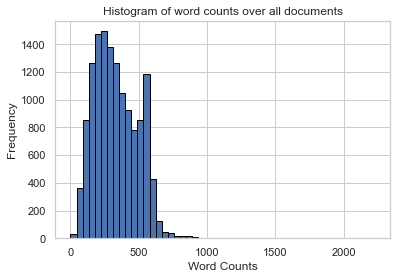

In [8]:
word_counts_per_doc = []
for selftxt in df_meta["selftext"]:
    selftxt = selftxt.replace("\n","")
    selftxt = selftxt.replace("&amp;#x200B;","")
    selftxt = selftxt.replace("&amp;", "and")
    
    word_counts_per_doc.append(len(selftxt.split(" ")))

plt.title("Histogram of word counts over all documents")
plt.hist(word_counts_per_doc, bins = 50, edgecolor = "black");
plt.xlabel("Word Counts")
plt.ylabel("Frequency");

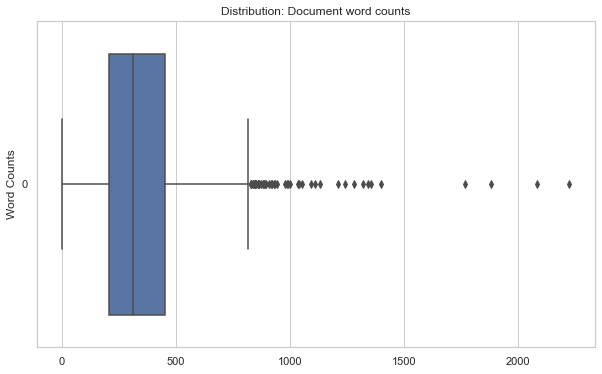

In [9]:
fig = plt.figure(num=1, figsize = (10,6))
sns.boxplot(data = word_counts_per_doc, orient = "h")
plt.title("Distribution: Document word counts")
plt.ylabel("Word Counts");

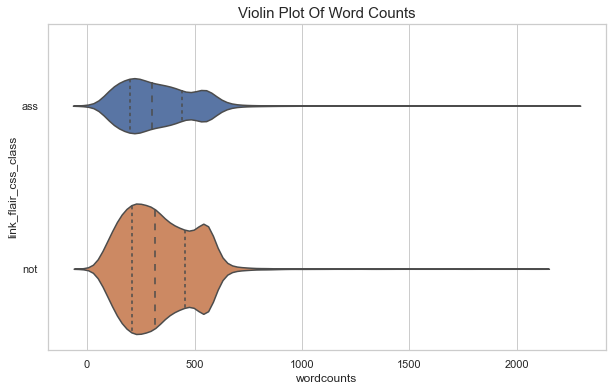

In [10]:
fig = plt.figure(num=1, figsize = (10,6))
plt.title("Violin plot of word counts".title(), fontsize = 15)
sns.violinplot( x = "wordcounts",y = "link_flair_css_class", data = df_meta, scale = "count", inner = "quartile", bw = 0.2);

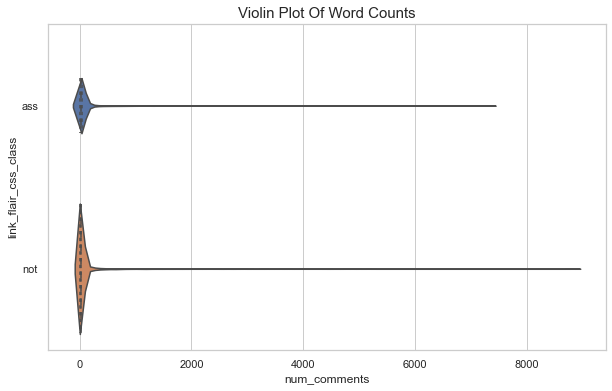

In [999]:
fig = plt.figure(num=1, figsize = (10,6))
plt.title("Violin plot of word counts".title(), fontsize= 15)
sns.violinplot( x = "num_comments",y = "link_flair_css_class", data = df_meta, scale = "count", inner = "quartile");

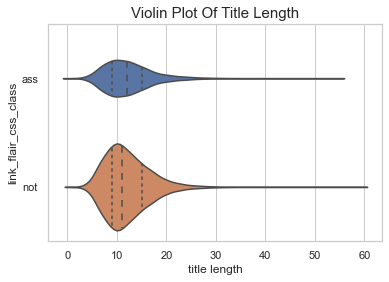

In [12]:
meta_copy = df_meta.copy()


meta_copy["title length"] = meta_copy["title"].apply(lambda x: len(x.split(" ")))
plt.title("Violin plot of title length".title(), fontsize = 15)

sns.violinplot(data= meta_copy, x = "title length", y = "link_flair_css_class", scale = "count", inner= "quartile");

## what stopwords are in nltk and spacy

In [13]:
nlp = spacy.load("en_core_web_sm")
nltk_stop_words = nltk_stopwords.words("english")
spacy_stop_words = nlp.Defaults.stop_words
print(set(nltk_stop_words) - spacy_stop_words) #only in nltk
print()
print( spacy_stop_words - set(nltk_stop_words))# only in spacy

{"she's", 'aren', "doesn't", "wouldn't", 'haven', "mightn't", "you'd", 'didn', "didn't", "isn't", "mustn't", 'll', "should've", "it's", 'wouldn', 'shouldn', 'weren', 'm', 'won', "hadn't", 'doesn', 'wasn', 't', "shouldn't", "haven't", 'ma', "that'll", "you'll", 'hasn', "hasn't", "you've", 'shan', 've', 'having', 'don', "you're", "don't", 'mightn', 'y', 'isn', 'd', 's', "aren't", 'hadn', 'o', 'couldn', 'ain', 'mustn', "weren't", 'theirs', "won't", "couldn't", "shan't", "needn't", "wasn't", 'needn'}

{'may', 'could', 'perhaps', 'make', 'whence', 'serious', 'eleven', 'two', 'also', 'whether', 'next', 'moreover', 'whereby', 'move', 'whither', 'anyhow', 'always', 'via', 'along', '’ve', 'hundred', 'whatever', 'namely', 'back', 'thereafter', "'m", 'often', 'nevertheless', 'keep', 'everything', 'thru', 'thence', 'others', 'nine', 'ten', 'without', 'becomes', 'everywhere', 'n’t', 'alone', 'one', 'name', 'take', 'using', 'hereafter', '‘s', '‘ve', 'however', 'anywhere', 'together', 'third', 'acros

### Cleaning data using pipeline

In [1000]:
def pipeline_func(data, fns):
    """Pipeline function that applies all functions taken in to the data
    data: string data
    fns: list of functions
    
    ex: pipeline_func(data, [fn1, fn2, fn3])
    
    """
    
    return functools.reduce(lambda a,x: x(a), fns, data)

# prepare functions for pipeline
def remove_newline(txt):
    """remove '\n' """
    return map(lambda x: x.replace("\n"," "), txt)
def remove_trip_space(txt):
    """remove triple spaces to single"""
    return map(lambda x: x.replace("   "," "), txt)

def remove_dub_space(txt):
    """remove double spaced made from remove_newline function"""
    return map(lambda x: x.replace("  "," "), txt)

def remove_amphex(txt):
    """remove ''&amp;#x200b' """
    return map(lambda x: x.replace("&amp;#x200B"," "), txt)
def change_amp(txt):
    """remove '&amp;' """
    return map(lambda x: x.replace("&amp;","and"), txt)

def to_lower(txt):
    """returns lower case text"""
    return map(lambda x: x.lower(), txt)

def remove_href(txt):
    """remove any string that has url format"""
    return map(lambda x: re.sub("http\S+", " ",x), txt)

def remove_number(txt):
    """remove numerical string in the txt"""
    return map(lambda x: re.sub("\d+"," ", x), txt)
    

def remove_accented_char(txt):
    """remove accented characters from text e.g. cafe`"""
    return map(lambda x: unidecode.unidecode(x), txt)

def remove_punc(txt):
    """remove punctuations"""
    return map(lambda x: re.sub("["+string.punctuation+"]", " ", x), txt)

In [176]:
# apply text cleaning
func_list = [remove_newline, remove_amphex,
             change_amp, to_lower,remove_href,remove_number, remove_accented_char, remove_punc]
df_meta["cleaned_txt_wo_punc"] =[cleaned_txt for cleaned_txt in pipeline_func(df_meta["selftext"].values, func_list)]

func_list = [remove_newline, remove_amphex,
             change_amp, to_lower,remove_href, remove_number,remove_accented_char]
df_meta["cleaned_txt_w_punc"] = [cleaned_txt for cleaned_txt in pipeline_func(df_meta["selftext"].values,func_list)]

In [723]:
def remove_domain_specific(txt,toremove = ["aita","wibta","AITA","WIBTA","asshole"]):
    """remove domain specific words"""
    for tr in toremove:
        txt = txt.replace(tr, " ")
    return txt
        
#df_meta["cleaned_txt_wo_punc_domspec"] = df_meta["cleaned_txt_wo_punc"].apply(remove_domain_specific)

In [1002]:
# collect strings that has &
findings = []
for st in df_meta["selftext"].values:
    if "&" in st:
        findings.append(st)

# find html symbols using regex
# so it doesn't remove non html string that has & in
symbols = []
for find in findings:
    for f in re.findall("&\S+;", find):
        symbols.append(f)

def remove_unwanted(txt):
    for symbol in set(symbols):
        txt = txt.replace(symbol,"")
    return txt
df_meta["selftext"].astype("string")

df_meta["new_selftext"] = df_meta["selftext"].apply(lambda x: re.sub("http\S+", " ",x))
df_meta["new_selftext"].astype("string")
df_meta["new_selftext"] = df_meta["new_selftext"].str.replace("&\S+;","", regex=True)
df_meta["new_selftext"] = df_meta["new_selftext"].apply(remove_domain_specific)

In [728]:
# text cleaning and preprocessing using spacy
nlp = spacy.load("en_core_web_sm")
new_selftxt= []
for doc in nlp.pipe(df_meta["new_selftext"].values):
    new_selftxt.append(" ".join([token.lemma_.lower() for token in doc if not token.is_stop and
                    not token.is_punct and not token.is_space and
                    token.ent_type_ not in ["PERSON","GPE","ORG"] and token.pos_ != "NUM"])        )
df_meta["new_selftext_tokens"] = new_selftxt

### remove named entities using spacy

In [462]:
# store spacy docs in doc bins
docbin_w_punc = spacy.tokens.DocBin()
nlp = spacy.load("en_core_web_sm")
# fill in doc bin for clean text without punc
pbar = tqdm_notebook(total = len(df_meta["cleaned_txt_w_punc"].values), desc = "clean_txt_w_punc")
for doc in nlp.pipe(df_meta["cleaned_txt_w_punc"].values, n_process = -1):
    docbin_w_punc.add(doc)
    pbar.update(1)

clean_txt_w_punc:   0%|          | 0/13613 [00:00<?, ?it/s]

clean_txt_wo_punc:   0%|          | 0/13613 [00:00<?, ?it/s]

In [463]:
# test doc binsize
assert len(docbin_w_punc) == len(df_meta["cleaned_txt_w_punc"])

In [526]:
docbin_selftext = spacy.tokens.DocBin()
nlp = spacy.load("en_core_web_sm")
for doc in nlp.pipe(df_meta["selftext"].values, n_process = -1):
    docbin_selftext.add(doc)

In [527]:
assert len(docbin_selftext) == len(df_meta["selftext"])

In [470]:
docbin_w_punc_bytes = docbin_w_punc.to_bytes()

In [529]:
nlp = spacy.blank("en")
docs_w_punc = list(docbin_w_punc.get_docs(nlp.vocab))
nlp = spacy.blank("en")
docs_wo_punc = list(docbin_wo_punc.get_docs(nlp.vocab))
nlp = spacy.blank("en")
docs_selftext = list(docbin_selftext.get_docs(nlp.vocab))

In [484]:
for doc in docs_wo_punc[:10]:
    # observe entities
    print([(ent.text, ent.label_) for ent in doc.ents])

print("\n")
for doc in docs_w_punc[:10]:
    # observe entities
    print([(ent.text, ent.label_) for ent in doc.ents])

[]
[]
[('a few months ago', 'DATE')]
[]
[('tonight', 'TIME'), ('an hour and half later', 'TIME'), ('an extra hour', 'TIME')]
[]
[('first', 'ORDINAL'), ('two years', 'DATE'), ('a year ago', 'DATE'), ('a few minutes', 'TIME')]
[('summer', 'DATE'), ('today', 'DATE')]
[('a week', 'DATE'), ('tomorrow', 'DATE'), ('about   minutes', 'TIME'), ('about   minutes', 'TIME'), ('the three hours', 'TIME')]
[('one', 'CARDINAL'), ('the other day', 'DATE')]


[]
[]
[('a few months ago', 'DATE')]
[]
[('my.mother', 'PERSON'), ('tonight', 'TIME'), ('an hour and half later', 'TIME'), ('an extra hour', 'TIME')]
[]
[('first', 'ORDINAL'), ('two years', 'DATE'), ('a year ago', 'DATE'), ('and few days ago', 'DATE'), ('a few minutes', 'TIME')]
[('summer', 'DATE'), ('today', 'DATE')]
[('a week', 'DATE'), ('tomorrow', 'DATE'), ('about   minutes', 'TIME'), ('about   minutes', 'TIME'), ('the three hours', 'TIME')]
[('one', 'CARDINAL'), ('the other day', 'DATE')]


### Vectorize documents with preprocessed text

In [732]:
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words=list(meta_sw))

tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(strip_accents = "unicode",
        stop_words = list(meta_sw),
        norm = "l2",  #‘l2’: Sum of squares of vector elements is 1. 
        #The cosine similarity between two vectors is their dot product when 
        #l2 norm has been applied.
        )
count_vecs= count_vectorizer.fit_transform(df_meta["new_selftext_tokens"].values)
tfidf_vecs = tfidf_vectorizer.fit_transform(df_meta["new_selftext_tokens"].values)



In [359]:
print("Printing for count vectorized tokens")
print(count_vectorizer.get_feature_names())
print(count_vecs.toarray()[0])


print("Printing for tfidf vectorized tokens")
print(tfidf_vectorizer.get_feature_names())
print(tfidf_vecs.toarray()[0])

Printing for count vectorized tokens
['aa', 'aaa', 'aaaalways', 'aaaand', 'aaand', 'aah', 'aam', 'aand', 'aanda', 'aande', 'aandr', 'aaron', 'ab', 'aba', 'aback', 'abandon', 'abandonment', 'abandonned', 'abba', 'abbey', 'abbh', 'abbreviate', 'abbreviation', 'abby', 'abc', 'abcd', 'abcess', 'abcesses', 'abd', 'abdomen', 'abdominal', 'abe', 'aberdeen', 'abet', 'abhor', 'abhorrence', 'abhorrent', 'abide', 'abiguity', 'ability', 'abit', 'abkut', 'able', 'abled', 'ableism', 'ableist', 'abliest', 'ablism', 'abnormal', 'abnormality', 'abnormally', 'abo', 'aboard', 'abomination', 'abondon', 'aboot', 'aboriginal', 'aborrent', 'abort', 'abortion', 'aboutnmy', 'abouts', 'abput', 'abraham', 'abrasive', 'abreast', 'abridge', 'abroad', 'abrsm', 'abrupt', 'abruptly', 'abscess', 'abseentism', 'absence', 'absent', 'absentee', 'absently', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absoluty', 'absolve', 'absorb', 'absorbe', 'absorbent', 'abstain', 'abstention', 'abstract', 'absud', 'absurd', '

[0 0 0 ... 0 0 0]
Printing for tfidf vectorized tokens
['aa', 'aaa', 'aaaalways', 'aaaand', 'aaand', 'aah', 'aam', 'aand', 'aanda', 'aande', 'aandr', 'aaron', 'ab', 'aba', 'aback', 'abandon', 'abandonment', 'abandonned', 'abba', 'abbey', 'abbh', 'abbreviate', 'abbreviation', 'abby', 'abc', 'abcd', 'abcess', 'abcesses', 'abd', 'abdomen', 'abdominal', 'abe', 'aberdeen', 'abet', 'abhor', 'abhorrence', 'abhorrent', 'abide', 'abiguity', 'ability', 'abit', 'abkut', 'able', 'abled', 'ableism', 'ableist', 'abliest', 'ablism', 'abnormal', 'abnormality', 'abnormally', 'abo', 'aboard', 'abomination', 'abondon', 'aboot', 'aboriginal', 'aborrent', 'abort', 'abortion', 'aboutnmy', 'abouts', 'abput', 'abraham', 'abrasive', 'abreast', 'abridge', 'abroad', 'abrsm', 'abrupt', 'abruptly', 'abscess', 'abseentism', 'absence', 'absent', 'absentee', 'absently', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absoluty', 'absolve', 'absorb', 'absorbe', 'absorbent', 'abstain', 'abstention', 'abstract', 'a

[0. 0. 0. ... 0. 0. 0.]


In [756]:
print(df_meta.iloc[10776,:]["selftext"])

UPDATE: Thank you to everyone who commented and provided thoughtful  suggestions and feedback. My wife read all your comments with me and today she apologized and admitted that she was the asshole for not taking into consideration that this was a long tradition that my dad, brother, and me wanted to maintain privately among ourselves and now with my son. She’s already told her dad that he can join us in the evenings when we’re home if he wants to hang out with my dad. Her dad agreed and had no problem, understanding that this was my family’s tradition. Thank you again. 

For background, my nuclear family lives in the hometown where my wife grew up near her parents, siblings, and some extended relatives. My own parents and brother live in different states so it’s not often that we can spend time together. Growing up, when my dad was able to take days off from his two jobs, he would take my brother and I on fishing trips for a couple of days to bond. As my brother and I got older, we mov

In [740]:
count_nmf_model = decomposition.NMF(7, max_iter = 1000)
tfidf_nmf_model = decomposition.NMF(7, max_iter = 1000)
count_vec_topics = count_nmf_model.fit_transform(count_vecs)
tfidf_vec_topics = tfidf_nmf_model.fit_transform(tfidf_vecs)

In [788]:
df_meta["tfidf_topic_labels"] = tfidf_vec_topics.argmax(axis=1)
# give actual name of topics
tfidf_vec_topic_dict = {0: "Family", 1:"Friends", 2:"Pets", 3:"Work", 4:"Payments", 5:"Vehicles/Cars", 6:"Roommates/Housemantes"}
df_meta["tfidf_topic_class"] = df_meta["tfidf_topic_labels"].apply(lambda x: tfidf_vec_topic_dict[x])
df_meta["tfidf_topic_class"]

0                         Work
1        Roommates/Housemantes
2                      Friends
3                     Payments
4                Vehicles/Cars
                 ...          
13608                 Payments
13609                     Work
13610                   Family
13611                   Family
13612                     Work
Name: tfidf_topic_class, Length: 13613, dtype: object

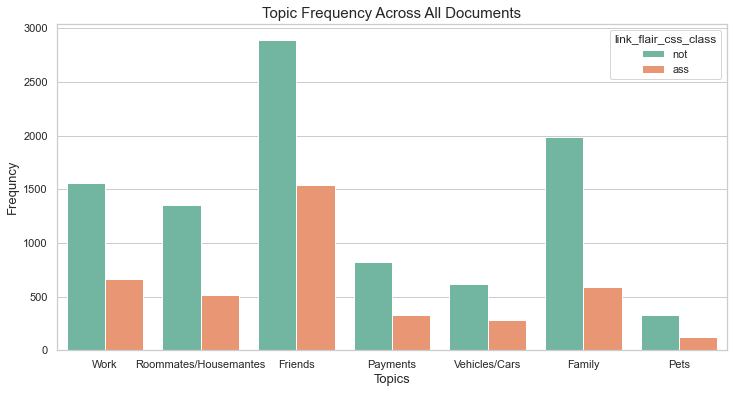

In [838]:
# check what topics are appeared in two classes
plt.figure(figsize=(12,6))
plt.title("topic frequency across all documents".title(), fontsize=15)
sns.countplot(data=df_meta, x="tfidf_topic_class", hue="link_flair_css_class", palette="Set2", hue_order = ["not","ass"]);
plt.xlabel("Topics", fontsize=13);
plt.ylabel("Frequncy", fontsize=13);
plt.savefig("src/img/topic_freq_across_docs.png", dpi=300, transparent=True);

In [891]:
# get the count of each class
aggregated = df_meta.groupby(["link_flair_css_class","tfidf_topic_class"])[["tfidf_topic_labels"]].agg("count")

In [917]:
new_agg = aggregated.reset_index()
ass_cnt = new_agg[new_agg["link_flair_css_class"] == "ass"]["tfidf_topic_labels"].sum()
not_cnt = new_agg[new_agg["link_flair_css_class"] == "not"]["tfidf_topic_labels"].sum()

ass_norm = (new_agg[new_agg["link_flair_css_class"] == "ass"]['tfidf_topic_labels'] / ass_cnt).values
not_norm = (new_agg[new_agg["link_flair_css_class"] == "not"]['tfidf_topic_labels'] / not_cnt).values

new_agg["_counts"] = list(ass_norm)+list(not_norm)
print(ass_cnt, not_cnt)
new_agg 

4043 9570


,link_flair_css_class,tfidf_topic_class,tfidf_topic_labels,norm_counts
0,ass,Family,588,0.145437
1,ass,Friends,1542,0.381400
2,ass,Payments,329,0.081375
3,ass,Pets,122,0.030176
4,ass,Roommates/Housemantes,513,0.126886
5,ass,Vehicles/Cars,284,0.070245
6,ass,Work,665,0.164482
7,not,Family,1990,0.207941
8,not,Friends,2895,0.302508
9,not,Payments,825,0.086207


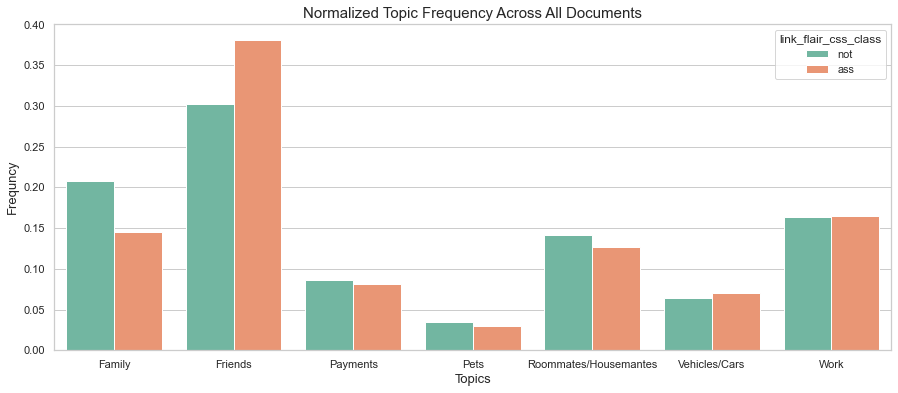

In [918]:
# check what topics are appeared in two classes
plt.figure(figsize=(15,6))
plt.title("normalized topic frequency across all documents".title(), fontsize=15)
sns.barplot(data=new_agg, x="tfidf_topic_class", y = "norm_counts", hue="link_flair_css_class", palette="Set2",
        hue_order = ["not","ass"]);
plt.xlabel("Topics", fontsize=13);
plt.ylabel("Frequncy", fontsize=13);
plt.savefig("src/img/topic_freq_across_docs_norm.png", dpi=300, transparent=True);

In [951]:
# investigate the most frequent words from family and friends topics
friends = df_meta[df_meta["tfidf_topic_class"] == "Friends"]
family = df_meta[df_meta["tfidf_topic_class"] == "Family"]
topic_strength = pd.DataFrame(tfidf_vec_topics, columns = "Family Friends Pets Work Payments Vehicle/Car Roommates/Housemates".split())
topic_strength
# fn = tfidf_vectorizer.get_feature_names()
# pd.DataFrame(tfidf_vectorizer.idf_, index = fn).sort_values(0)

,Family,Friends,Pets,Work,Payments,Vehicle/Car,Roommates/Housemates
0,0.000000,0.000000,0.000000,0.019990,0.000000,0.000000,0.000000
1,0.011158,0.015861,0.007657,0.000000,0.000000,0.017534,0.050409
2,0.003387,0.031920,0.002705,0.004811,0.000000,0.002752,0.015002
3,0.011513,0.017707,0.000642,0.014303,0.040547,0.022289,0.001546
4,0.011032,0.019628,0.000530,0.017880,0.021934,0.039072,0.000569
...,...,...,...,...,...,...,...
13608,0.015578,0.016140,0.000010,0.002675,0.018921,0.011485,0.011079
13609,0.000000,0.031912,0.002170,0.071562,0.008357,0.000842,0.000000
13610,0.062681,0.000000,0.000000,0.051587,0.000000,0.000000,0.021437
13611,0.073583,0.000000,0.000000,0.017572,0.000000,0.000000,0.000000


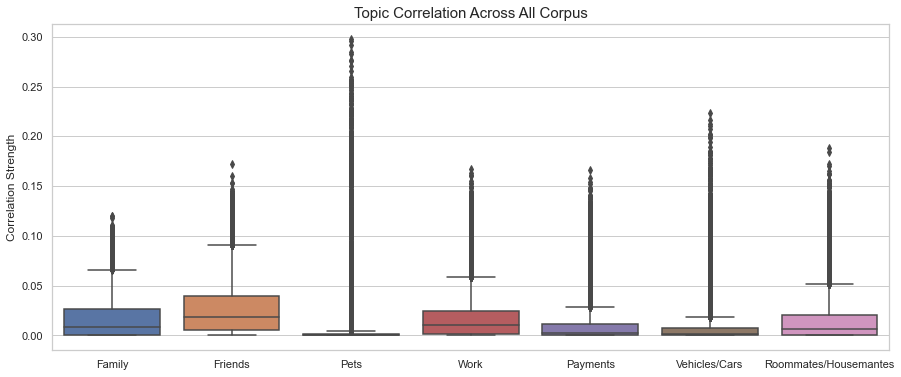

In [831]:
plt.figure(figsize=(15,6))
plt.title("topic correlation across all corpus".title(), fontsize=15)
sns.boxplot(data=pd.DataFrame(tfidf_vec_topics, columns = list(np.array(list(tfidf_vec_topic_dict.items()))[:,1])), );
plt.ylabel("correlation strength".title());

In [839]:
# observe what words are prominent in each topics
cv_feature_names = count_vectorizer.get_feature_names()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

count_nmf_tops = count_nmf_model.components_.argsort(axis =1)[:, -1:-21:-1]
tfidf_nmf_tops = tfidf_nmf_model.components_.argsort(axis =1)[:, -1:-21:-1]

cv_topics = [[cv_feature_names[e] for e in l] for l in count_nmf_tops]
tf_topics = [[tfidf_feature_names[e] for e in l] for l in tfidf_nmf_tops]




for i, topic in enumerate(cv_topics):
    print("topic{}: {}".format(i, " ".join(topic)))

print("\n")    

for i, topic in enumerate(tf_topics):
    print("topic{}: {}".format(i, " ".join(topic)))

topic0: mom family dad year sister want parent brother kid time mother live house old come home know wife father child
topic1: friend good year group time talk know want hang girl close people party meet invite come guy month school ask
topic2: work time day week job come hour home leave ask need start night month help long year stay boss sleep
topic3: tell ask know talk think start come day leave try need happen later stop guy week ago look want let
topic4: like feel want know think thing people time try talk ask look way bad start guy lot good nt right
topic5: dog walk cat house home leave time live come let room care run away park try pet owner neighbor bark
topic6: pay money car ask want month buy rent live house need help job bill year new drive parent cost save


topic0: mom dad sister family brother parent kid mother year want tell father child wife old know like wedding time son
topic1: friend tell talk like know want feel girl good group guy think time hang ask people date yea

In [992]:
# find the sample with highest correlation according to the topic
top_n_samples = 10
topic_to_observe = "Friends"
indices = topic_strength.sort_values(by=topic_to_observe,ascending=False).head(top_n_samples).index.tolist()
df_meta.loc[indices,["permalink","link_flair_css_class"]].values

array([['/r/AmItheAsshole/comments/ct0lw9/aita_for_shittalking_my_emotionally_abusive_best/',
        'ass'],
       ['/r/AmItheAsshole/comments/cos89v/aita_for_not_wanting_my_friend_to_talk_to_my_ex/',
        'not'],
       ['/r/AmItheAsshole/comments/cmv4wt/aita_for_stop_being_friends_with_someone_because/',
        'ass'],
       ['/r/AmItheAsshole/comments/cw7bla/wibta_if_i_told_my_best_friends_boyfriend_that/',
        'ass'],
       ['/r/AmItheAsshole/comments/cqdanm/wibta_if_i_block_a_friend_on_social_media_that/',
        'not'],
       ['/r/AmItheAsshole/comments/cnzxtr/aita_for_not_wanting_to_be_friends_with_my_ex_a/',
        'not'],
       ['/r/AmItheAsshole/comments/cm4nef/aita_for_liking_my_exs_friend/',
        'not'],
       ['/r/AmItheAsshole/comments/ct7snt/aita_for_rejecting_a_guy_i_was_apparently_leading/',
        'not'],
       ['/r/AmItheAsshole/comments/cnehcl/aita_did_i_lead_on_my_previous_best_friend/',
        'not'],
       ['/r/AmItheAsshole/comments/cm5bo

In [997]:
# find documents with the highest strength to each topics
for t in topic_strength.columns.tolist():
    i = topic_strength.sort_values(by=t, ascending=False).head(1).index.tolist()
    print(topic_strength.sort_values(by=t, ascending=False).head(3))
    print(df_meta.loc[i,["permalink","link_flair_css_class"]].values, t)

        Family   Friends  Pets      Work  Payments  Vehicle/Car  \
9431  0.120003  0.004653   0.0  0.003169       0.0     0.000953   
8304  0.119828  0.000000   0.0  0.000000       0.0     0.000000   
1915  0.118346  0.000000   0.0  0.000000       0.0     0.000000   

      Roommates/Housemates  
9431                   0.0  
8304                   0.0  
1915                   0.0  
[['/r/AmItheAsshole/comments/cra35e/aita_for_not_hanging_out_with_a_halfbrother_i/'
  'not']] Family
       Family   Friends  Pets  Work  Payments  Vehicle/Car  \
13411     0.0  0.172549   0.0   0.0       0.0          0.0   
461       0.0  0.159702   0.0   0.0       0.0          0.0   
13156     0.0  0.153515   0.0   0.0       0.0          0.0   

       Roommates/Housemates  
13411              0.000000  
461                0.000000  
13156              0.008573  
[['/r/AmItheAsshole/comments/ct0lw9/aita_for_shittalking_my_emotionally_abusive_best/'
  'ass']] Friends
      Family   Friends      Pets  Work  

In [744]:
# convert to genism
count_corpus = matutils.Sparse2Corpus(count_vecs.T)
tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.T)

count_id2w = dict((v,k) for k, v in count_vectorizer.vocabulary_.items())
tfidf_id2w = dict((v,k) for k, v in tfidf_vectorizer.vocabulary_.items())

print(len(count_id2w))
print(len(tfidf_id2w))

25708
25687


In [747]:
for num_topic in  range(1, 7,1):
    print("number of topics {} (reduced dimension)".format(num_topic))
    count_lda = models.LdaModel(count_corpus,num_topics = num_topic, id2word = count_id2w, passes = 10, random_state = 789)
    tfidf_lda = models.LdaModel(tfidf_corpus,num_topics = num_topic, id2word = tfidf_id2w, passes = 10, random_state = 789)
    
    print("terms for topics in count vectorized docs")
    count_lda_topics = count_lda.print_topics(num_topics = -1, num_words = 15)
    for topic in count_lda_topics:
        print("topic {} : {}".format(topic[0], topic[1]), end="\n\n")

    print()
    print("terms for topics in tfidf vectorized docs")
    tfidf_lda_topics = tfidf_lda.print_topics(num_topics = -1, num_words = 15)
    for topic in tfidf_lda_topics:
        print("topic {}: {}".format(topic[0], topic[1]), end="\n\n")
        
    print()

number of topics 1 (reduced dimension)
terms for topics in count vectorized docs
topic 0 : 0.014*"tell" + 0.013*"want" + 0.013*"like" + 0.012*"friend" + 0.011*"time" + 0.010*"know" + 0.009*"ask" + 0.008*"think" + 0.008*"feel" + 0.007*"work" + 0.007*"year" + 0.007*"come" + 0.007*"day" + 0.006*"thing" + 0.006*"talk"


terms for topics in tfidf vectorized docs
topic 0: 0.005*"friend" + 0.004*"tell" + 0.004*"want" + 0.004*"like" + 0.004*"time" + 0.003*"know" + 0.003*"ask" + 0.003*"work" + 0.003*"feel" + 0.003*"think" + 0.003*"year" + 0.003*"day" + 0.003*"talk" + 0.002*"come" + 0.002*"mom"


number of topics 2 (reduced dimension)
terms for topics in count vectorized docs
topic 0 : 0.015*"like" + 0.015*"friend" + 0.015*"tell" + 0.010*"know" + 0.010*"ask" + 0.009*"think" + 0.009*"time" + 0.009*"want" + 0.007*"people" + 0.007*"feel" + 0.007*"talk" + 0.007*"start" + 0.007*"come" + 0.006*"work" + 0.006*"try"

topic 1 : 0.016*"want" + 0.014*"tell" + 0.013*"time" + 0.012*"year" + 0.010*"like" + 0.

### Clustering/Decompositioning with T-SNE

#### Reduce demension to 3

In [283]:
cv_tsne = manifold.TSNE(n_components = 3, metric = "cosine", n_jobs = -1, perplexity = 10.0, learning_rate = 20, angle = 0.3)
tfidf_tsne = manifold.TSNE(n_components = 3, metric = "cosine", n_jobs = -1, perplexity = 10.0, learning_rate =20, angle = 0.3)
count_vecs_tsne = cv_tsne.fit_transform(count_vecs)
tfidf_vecs_tsne = tfidf_tsne.fit_transform(tfidf_vecs)

In [293]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")

lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)
ax.scatter(count_vecs_tsne[:,0],count_vecs_tsne[:,1],count_vecs_tsne[:,2], c= classes, cmap = plt.cm.copper)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


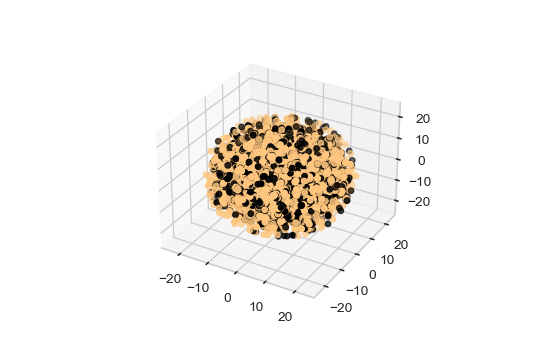

In [292]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")

lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)
ax.scatter(tfidf_vecs_tsne[:,0],tfidf_vecs_tsne[:,1],tfidf_vecs_tsne[:,2], c= classes, cmap = plt.cm.copper)

#### Same process with 2D

In [1003]:
cv_tsne = manifold.TSNE(n_components = 2, metric = "cosine", n_jobs = -1, perplexity = 10.0, learning_rate = 20, angle = 0.3)
tfidf_tsne = manifold.TSNE(n_components = 2, metric = "cosine", n_jobs = -1, perplexity = 10.0, learning_rate =20, angle = 0.3)
count_vecs_tsne = cv_tsne.fit_transform(count_vecs)
tfidf_vecs_tsne = tfidf_tsne.fit_transform(tfidf_vecs)

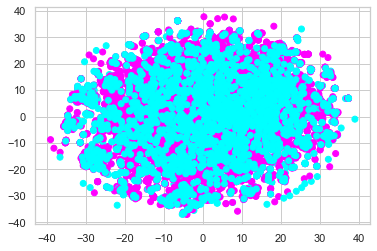

In [1006]:
lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)

plt.scatter(count_vecs_tsne[:,0], count_vecs_tsne[:,1], c = classes, cmap = plt.cm.cool);

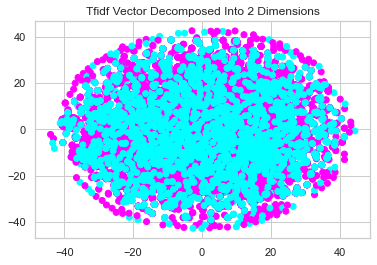

In [1005]:
lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)

plt.scatter(tfidf_vecs_tsne[:,0], tfidf_vecs_tsne[:,1], c = classes, cmap = plt.cm.cool);
plt.title("tfidf vector decomposed into 2 dimensions".title());

same process but with metrics set to euclidean distance

In [269]:
cv_tsne = manifold.TSNE(n_components = 2, n_jobs = -1)
tfidf_tsne = manifold.TSNE(n_components = 2, n_jobs = -1)
count_vecs_tsne = cv_tsne.fit_transform(count_vecs)
tfidf_vecs_tsne = tfidf_tsne.fit_transform(tfidf_vecs)

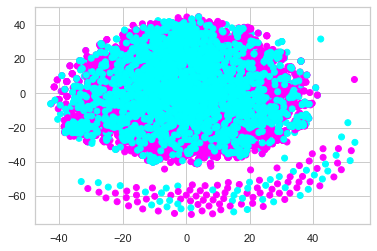

In [270]:
lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)

plt.scatter(count_vecs_tsne[:,0], count_vecs_tsne[:,1], c = classes, cmap = plt.cm.cool)

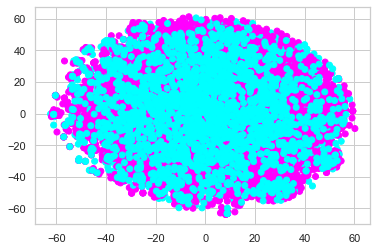

In [271]:
lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)

plt.scatter(tfidf_vecs_tsne[:,0], tfidf_vecs_tsne[:,1], c = classes, cmap = plt.cm.cool)

#### Reducing demension using LSA

In [299]:
count_lsa = decomposition.TruncatedSVD(2, n_iter = 10)
tfidf_lsa = decomposition.TruncatedSVD(2, n_iter = 10)

lsa_count_topics = count_lsa.fit_transform(count_vecs)
lsa_tfidf_topics = tfidf_lsa.fit_transform(tfidf_vecs)

In [298]:
# explained ratio in remaining demension
tfidf_lsa.explained_variance_ratio_

array([0.00512082, 0.00803658])

<IPython.core.display.Javascript object>


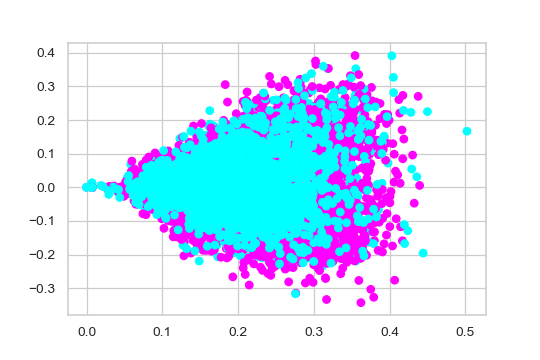

In [319]:
lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)
fig = plt.figure()
plt.title("scatter plot of two classes in reduced dimension from tfidf vectors".title(), fontsize = 13)
plt.scatter(lsa_tfidf_topics[:,0], lsa_tfidf_topics[:,1], c = classes, cmap = plt.cm.cool);

<IPython.core.display.Javascript object>


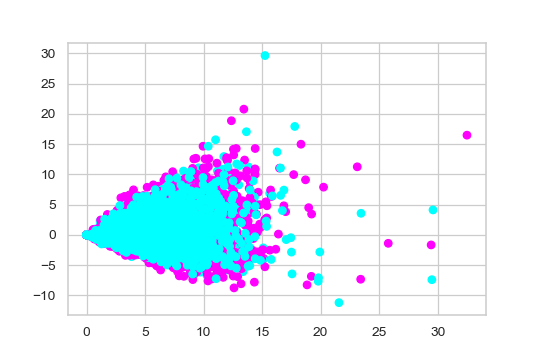

In [320]:
lb =  skl.preprocessing.LabelBinarizer()
classes = lb.fit_transform(df_meta["link_flair_css_class"].values)
fig = plt.figure()
plt.title("scatter plot of two classes in reduced dimension from count vectors".title(), fontsize = 13)
plt.scatter(lsa_count_topics[:,0], lsa_count_topics[:,1], c = classes, cmap = plt.cm.cool);

In [352]:
# for something funny
# find which doc has "karen" or "terry"
df_meta["has_karen"] = df_meta["cleaned_txt_wo_punc"].apply(lambda x: "karen" in x)
df_meta["has_terry"] = df_meta["cleaned_txt_wo_punc"].apply(lambda x: "terry" in x)
mask = (df_meta["has_karen"] == True) | (df_meta["has_terry"] == True)
print("Numbers of post with word karen or terry in it: {}".format(len(df_meta[mask])))
print("Numbers of post with only karen in it: {}".format(len(df_meta[df_meta["has_karen"] ==True])))
print("Numbers of post with karen in it that is classified as asshole: {}".format((df_meta[df_meta["has_karen"] == True]["link_flair_css_class"] == "ass").sum()))
print("Numbers of post with terry in it that is classified as asshole: {}".format((df_meta[df_meta["has_terry"] == True]["link_flair_css_class"] == "ass").sum()))


Numbers of post with word karen or terry in it: 51
Numbers of post with only karen in it: 49
Numbers of post with karen in it that is classified as asshole: 16
Numbers of post with terry in it that is classified as asshole: 0


## Sentiment Analysis using Vader

In [362]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [370]:
sia = SentimentIntensityAnalyzer()
sentiment_dict = sia.polarity_scores(df_meta["cleaned_txt_w_punc"].values[1])

In [609]:
# vader analysis on all text variables
sentiment_selftext= df_meta["selftext"].apply(lambda x: sia.polarity_scores(x))
sentiment_df = pd.DataFrame(data = list(sentiment_selftext))
sentiment_df.columns = pd.MultiIndex.from_product([["sentiment_selftext"],["neg","neu","pos","compound"]])

x = list(df_meta["cleaned_txt_w_punc"].apply(lambda x: sia.polarity_scores(x)))
sentiment_df_sub0 = pd.DataFrame(x)
sentiment_df_sub0.columns = pd.MultiIndex.from_product([["sentiment_w_punc"],["neg","neu","pos","compound"]])
sentiment_df = pd.concat([sentiment_df, sentiment_df_sub0], axis=1)

x = list(df_meta["cleaned_txt_wo_punc"].apply(lambda x: sia.polarity_scores(x)))
sentiment_df_sub0 = pd.DataFrame(x)
sentiment_df_sub0.columns = pd.MultiIndex.from_product([["sentiment_wo_punc"],["neg","neu","pos","compound"]])
sentiment_df = pd.concat([sentiment_df, sentiment_df_sub0], axis = 1)
sentiment_df

sentiment_selftext                        sentiment_w_punc         \
                     neg    neu    pos compound              neg    neu   
0                  0.000  1.000  0.000   0.0000            0.000  1.000   
1                  0.097  0.765  0.138   0.9329            0.097  0.765   
2                  0.062  0.881  0.057   0.2120            0.063  0.880   
3                  0.125  0.705  0.170   0.7788            0.125  0.705   
4                  0.042  0.863  0.095   0.9766            0.042  0.862   
...                  ...    ...    ...      ...              ...    ...   
13608              0.056  0.916  0.028  -0.6681            0.057  0.916   
13609              0.177  0.730  0.093  -0.9826            0.176  0.731   
13610              0.028  0.912  0.060   0.9501            0.029  0.910   
13611              0.085  0.857  0.058  -0.6483            0.086  0.856   
13612              0.084  0.850  0.066   0.1017            0.084  0.850   

                      sentiment_wo_punc                         
         pos compound               neg    neu    pos compound  
0      0.000   0.0000             0.040  0.960  0.000  -0.3182  
1      0.138   0.9329             0.081  0.755  0.164   0.9783  
2      0.057   0.2120             0.059  0.885  0.056   0.0772  
3      0.170   0.7788             0.123  0.714  0.163   0.7405  
4      0.095   0.9766             0.034  0.866  0.099   0.9824  
...      ...      ...               ...    ...    ...      ...  
13608  0.028  -0.6681             0.054  0.919  0.027  -0.6271  
13609  0.093  -0.9826             0.169  0.742  0.089  -0.9826  
13610  0.061   0.9501             0.028  0.914  0.059   0.9471  
13611  0.059  -0.6483             0.081  0.863  0.056  -0.6483  
13612  0.066   0.1017             0.046  0.862  0.093   0.8584  

[13613 rows x 12 columns]

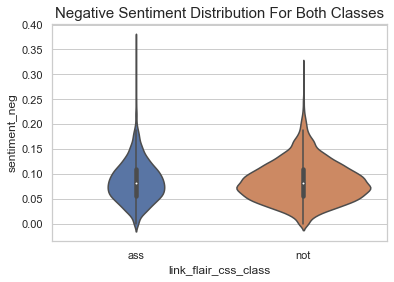

In [411]:
%matplotlib inline
plt.title("negative sentiment distribution for both classes".title(), fontsize = 15)
sns.violinplot(data= df_meta, y = "sentiment_neg",x= "link_flair_css_class", scale= "count");
plt.savefig("src/img/negative_sentiment_violin.png", dpi = 300)

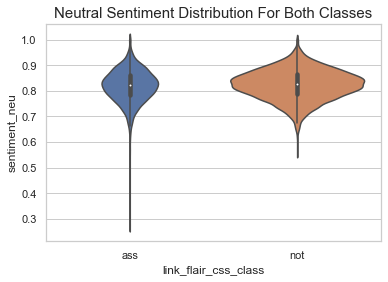

In [412]:
plt.title("neutral sentiment distribution for both classes".title(), fontsize = 15)
sns.violinplot(data= df_meta, y = "sentiment_neu",x= "link_flair_css_class", scale = "count")
plt.savefig("src/img/neutral_sentiment_violin.png", dpi=300)

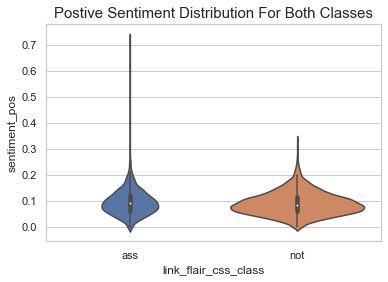

In [413]:
plt.title("postive sentiment distribution for both classes".title(), fontsize = 15)
sns.violinplot(data= df_meta, y = "sentiment_pos",x= "link_flair_css_class", scale="count");
plt.savefig("src/img/postive_sentiment_violin.png", dpi=300)